In [1]:
import pandas as pd
import numpy as np
import random
import os
from tqdm import tqdm

from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, ShuffleSplit

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import lightgbm as lgb


from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score

import matplotlib.pyplot as plt

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

In [3]:
DATA_DIR = 'D:/project/ICF_AutoCapsule_disabled/kaggle/home-credit-default-risk/'

In [4]:
def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(42)

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#device = 'cpu'
print(device)

cuda


## データ読み込み

In [8]:
train = pd.read_csv(DATA_DIR+'application_train.csv')
print(train.shape)
train.head()

(307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
test = pd.read_csv(DATA_DIR+'application_test.csv')
print(test.shape)
test.head()

(48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


## EDA

In [10]:
for col in train.select_dtypes('number').columns:
    print('-'*60)
    print(col)
    print(train[col].nunique())
    print(train[col].describe())

------------------------------------------------------------
SK_ID_CURR
307511
count    307511.000000
mean     278180.518577
std      102790.175348
min      100002.000000
25%      189145.500000
50%      278202.000000
75%      367142.500000
max      456255.000000
Name: SK_ID_CURR, dtype: float64
------------------------------------------------------------
TARGET
2
count    307511.000000
mean          0.080729
std           0.272419
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: TARGET, dtype: float64
------------------------------------------------------------
CNT_CHILDREN
15
count    307511.000000
mean          0.417052
std           0.722121
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          19.000000
Name: CNT_CHILDREN, dtype: float64
------------------------------------------------------------
AMT_INCOME_TOTAL
2548
count    3.075110e+05
mean     1.687979e+0

Name: REG_CITY_NOT_LIVE_CITY, dtype: float64
------------------------------------------------------------
REG_CITY_NOT_WORK_CITY
2
count    307511.000000
mean          0.230454
std           0.421124
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: REG_CITY_NOT_WORK_CITY, dtype: float64
------------------------------------------------------------
LIVE_CITY_NOT_WORK_CITY
2
count    307511.000000
mean          0.179555
std           0.383817
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: LIVE_CITY_NOT_WORK_CITY, dtype: float64
------------------------------------------------------------
EXT_SOURCE_1
114584
count    134133.000000
mean          0.502130
std           0.211062
min           0.014568
25%           0.334007
50%           0.505998
75%           0.675053
max           0.962693
Name: EXT_SOURCE_1, dtype: float64
-----------------------

Name: FLOORSMAX_MODE, dtype: float64
------------------------------------------------------------
FLOORSMIN_MODE
25
count    98869.000000
mean         0.228058
std          0.161160
min          0.000000
25%          0.083300
50%          0.208300
75%          0.375000
max          1.000000
Name: FLOORSMIN_MODE, dtype: float64
------------------------------------------------------------
LANDAREA_MODE
3563
count    124921.000000
mean          0.064958
std           0.081750
min           0.000000
25%           0.016600
50%           0.045800
75%           0.084100
max           1.000000
Name: LANDAREA_MODE, dtype: float64
------------------------------------------------------------
LIVINGAPARTMENTS_MODE
736
count    97312.000000
mean         0.105645
std          0.097880
min          0.000000
25%          0.054200
50%          0.077100
75%          0.131300
max          1.000000
Name: LIVINGAPARTMENTS_MODE, dtype: float64
------------------------------------------------------------
LIV

Name: FLAG_DOCUMENT_2, dtype: float64
------------------------------------------------------------
FLAG_DOCUMENT_3
2
count    307511.000000
mean          0.710023
std           0.453752
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: FLAG_DOCUMENT_3, dtype: float64
------------------------------------------------------------
FLAG_DOCUMENT_4
2
count    307511.000000
mean          0.000081
std           0.009016
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: FLAG_DOCUMENT_4, dtype: float64
------------------------------------------------------------
FLAG_DOCUMENT_5
2
count    307511.000000
mean          0.015115
std           0.122010
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: FLAG_DOCUMENT_5, dtype: float64
-----------------------------------------------------------

In [11]:
for col in train.select_dtypes('object').columns:
    print('-'*60)
    print(col)
    print(train[col].describe())
    print(train[col].value_counts(dropna=False))

------------------------------------------------------------
NAME_CONTRACT_TYPE
count         307511
unique             2
top       Cash loans
freq          278232
Name: NAME_CONTRACT_TYPE, dtype: object
Cash loans         278232
Revolving loans     29279
Name: NAME_CONTRACT_TYPE, dtype: int64
------------------------------------------------------------
CODE_GENDER
count     307511
unique         3
top            F
freq      202448
Name: CODE_GENDER, dtype: object
F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64
------------------------------------------------------------
FLAG_OWN_CAR
count     307511
unique         2
top            N
freq      202924
Name: FLAG_OWN_CAR, dtype: object
N    202924
Y    104587
Name: FLAG_OWN_CAR, dtype: int64
------------------------------------------------------------
FLAG_OWN_REALTY
count     307511
unique         2
top            Y
freq      213312
Name: FLAG_OWN_REALTY, dtype: object
Y    213312
N     94199
Name: FLAG_OWN_REA

### 使用する特徴量

In [12]:
# 使用する説明変数
cols_rm = ['SK_ID_CURR','TARGET']

cols_num = [col for col in train.select_dtypes('number').columns if col not in cols_rm]
cols_cat = [col for col in train.select_dtypes('object').columns if col not in cols_rm]
features = cols_num + cols_cat

### 欠損値補完
- 簡単のため、平均値補完と最頻値補完

In [13]:
train[cols_num] = train[cols_num].fillna(train[cols_num].mean())
train[cols_cat] = train[cols_cat].fillna(train[cols_cat].mode())

test[cols_num] = test[cols_num].fillna(test[cols_num].mean())
test[cols_cat] = test[cols_cat].fillna(test[cols_cat].mode())

### 分割

In [14]:
#kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# holdout
kf = ShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

## 1. Logistic Regression

In [13]:
X_train = train[features].copy(deep=True)
X_test = test[features].copy(deep=True)

y_train = train['TARGET'].copy(deep=True)

In [14]:
# ロジスティック回帰のパイプライン
lr_model = make_pipeline(
    OneHotEncoder(cols=cols_cat, use_cat_names=True),
    StandardScaler(),
    LogisticRegression(random_state=42),
)

In [15]:
# make_pipelineを使った場合、クラス名とパラメータ名をアンダーバー「2つ」でつなぐ
lr_params = {
    'logisticregression__penalty': ['elasticnet'],
    'logisticregression__solver': ['saga'],
    'logisticregression__l1_ratio': [i*0.2 for i in range(6)], 
    'logisticregression__C': [10**i for i in range(-3, 4)]
}

In [16]:
lr_gscv = GridSearchCV(lr_model, lr_params, scoring='roc_auc', cv=kf)
lr_gscv.fit(X_train, y_train)
lr_best = lr_gscv.best_estimator_
lr_pred = lr_best.predict_proba(X_test)[:,1]

print('LogisticRegression')
print(f'best_score: {lr_gscv.best_score_}')
print(f'best_params: {lr_gscv.best_params_}')

C:\Users\0000011306852\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\0000011306852\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\0000011306852\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\0000011306852\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\U

C:\Users\0000011306852\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\0000011306852\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\0000011306852\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\0000011306852\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\U

LogisticRegression
best_score: 0.7448633236220612
best_params: {'logisticregression__C': 0.01, 'logisticregression__l1_ratio': 0.4, 'logisticregression__penalty': 'elasticnet', 'logisticregression__solver': 'saga'}


In [17]:
pred_df = test[['SK_ID_CURR']]
pred_df['TARGET'] = lr_pred
pred_df.to_csv(DATA_DIR+'lr.csv', index=False)

C:\Users\0000011306852\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## 2. SVM

In [18]:
# X_train = train[features].copy(deep=True)
# X_test = test[features].copy(deep=True)

# y_train = train['TARGET'].copy(deep=True)

In [19]:
# # ロジスティック回帰のパイプライン
# svc_model = make_pipeline(
#     OneHotEncoder(cols=cols_cat, use_cat_names=True),
#     StandardScaler(),
#     SVC(random_state=42),
# )

In [20]:
# # make_pipelineを使った場合、クラス名とパラメータ名をアンダーバー2つでつなぐ
# svc_params = {
#     'svc__kernel': ['rbf'],
#     'svc__gamma': ['scale'],
#     'svc__C': [10**i for i in range(-3, 4)],
# }

In [21]:
# svc_gscv = GridSearchCV(svc_model, svc_params, scoring='roc_auc', cv=kf)
# svc_gscv.fit(X_train, y_train)
# svc_best = svc_gscv.best_estimator_
# svc_pred = svc_best.predict_proba(X_test)[:,1]

# print('SVM')
# print(f'best_score: {svc_gscv.best_score_}')
# print(f'best_params: {svc_gscv.best_params_}')

In [22]:
# pred_df = test[['SK_ID_CURR']]
# pred_df['TARGET'] = svc_pred
# pred_df.to_csv(DATA_DIR+'svm.csv', index=False)

## Random Forest

In [94]:
X_train = train[features].copy(deep=True)
X_test = test[features].copy(deep=True)

y_train = train['TARGET'].copy(deep=True)

In [95]:
# ランダムフォレストのパイプライン
rf_model = make_pipeline(
    OneHotEncoder(cols=cols_cat, use_cat_names=True),
    RandomForestClassifier(random_state=42, n_jobs=-1),
)

In [96]:
rf_params = {
    'randomforestclassifier__n_estimators': [10000],
    'randomforestclassifier__max_depth': [3, 5, 7]
}

In [97]:
rf_gscv = GridSearchCV(rf_model, rf_params, scoring='roc_auc', cv=kf)
rf_gscv.fit(X_train, y_train)
rf_best = rf_gscv.best_estimator_
rf_pred = rf_best.predict_proba(X_test)[:,1]

print('Random Forest')
print(f'best_score: {rf_gscv.best_score_}')
print(f'best_params: {rf_gscv.best_params_}')

C:\Users\0000011306852\AppData\Local\Programs\Python\Python36\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\Users\0000011306852\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\model_selection\_validation.py:530: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)


MemoryError: 

In [ ]:
pred_df = test[['SK_ID_CURR']]
pred_df['TARGET'] = rf_pred
pred_df.to_csv(DATA_DIR+'rf.csv', index=False)

## Gradient Boosting

In [28]:
X_train = train[features].copy(deep=True)
X_test = test[features].copy(deep=True)

y_train = train['TARGET'].copy(deep=True)

In [29]:
# ランダムフォレストのパイプライン
gbdt_model = make_pipeline(
    OneHotEncoder(cols=cols_cat, use_cat_names=True),
    GradientBoostingClassifier(random_state=42),
)

In [30]:
gbdt_params = {
    'gradientboostingclassifier__n_estimators': [300, 500, 700],
    'gradientboostingclassifier__max_depth': [3, 5, 7]
}

In [31]:
gbdt_gscv = GridSearchCV(gbdt_model, gbdt_params, scoring='roc_auc', cv=kf)
gbdt_gscv.fit(X_train, y_train)
gbdt_best = gbdt_gscv.best_estimator_
gbdt_pred = gbdt_best.predict_proba(X_test)[:,1]

print('Gradient Boosting')
print(f'best_score: {gbdt_gscv.best_score_}')
print(f'best_params: {gbdt_gscv.best_params_}')

Gradient Boosting
best_score: 0.7607549081831413
best_params: {'gradientboostingclassifier__max_depth': 3, 'gradientboostingclassifier__n_estimators': 700}


In [32]:
pred_df = test[['SK_ID_CURR']]
pred_df['TARGET'] = gbdt_pred
pred_df.to_csv(DATA_DIR+'gbdt.csv', index=False)

C:\Users\0000011306852\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## LightGBM

In [89]:
X_train = train[features].copy(deep=True)
X_test = test[features].copy(deep=True)

y_train = train['TARGET'].copy(deep=True)

In [90]:
X_train[cols_cat] = X_train[cols_cat].astype('category')
X_test[cols_cat] = X_test[cols_cat].astype('category')

In [91]:
params = {
    'objective': 'binary',
    'boosting': "gbdt",
    'metric': 'auc',
    'learning_rate': 0.01,
    'num_leaves': 31,
    'max_depth': -1,
    'verbosity': -1,
    'nthread': -1,
    'random_state': 42,
}

In [92]:
oof = np.zeros(len(X_train))
pred = np.zeros(len(X_test))
for fold_, (tr_idx, val_idx) in enumerate(kf.split(X_train.values, y_train.values)):
    print('-')
    print("Fold {}".format(fold_ + 1))

    tr_data = lgb.Dataset(X_train.iloc[tr_idx], label=y_train[tr_idx])
    val_data = lgb.Dataset(X_train.iloc[val_idx], label=y_train[val_idx])

    num_round = 10000
    clf = lgb.train(params, tr_data, num_round, valid_sets = [tr_data, val_data], verbose_eval=100, early_stopping_rounds=100)
    oof[val_idx] = clf.predict(X_train.iloc[val_idx], num_iteration=clf.best_iteration)
    pred += clf.predict(X_test, num_iteration=clf.best_iteration) / kf.n_splits

# val_score = roc_auc_score(y_train, oof)
# print('CV_AUC: ', val_score)

-
Fold 1
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.739631	valid_1's auc: 0.731629
[200]	training's auc: 0.755116	valid_1's auc: 0.743679
[300]	training's auc: 0.765754	valid_1's auc: 0.749829
[400]	training's auc: 0.773722	valid_1's auc: 0.7535
[500]	training's auc: 0.780392	valid_1's auc: 0.755593
[600]	training's auc: 0.786373	valid_1's auc: 0.756872
[700]	training's auc: 0.791864	valid_1's auc: 0.757681
[800]	training's auc: 0.797124	valid_1's auc: 0.758066
[900]	training's auc: 0.801995	valid_1's auc: 0.758233
[1000]	training's auc: 0.8065	valid_1's auc: 0.758494
[1100]	training's auc: 0.810821	valid_1's auc: 0.758671
[1200]	training's auc: 0.814737	valid_1's auc: 0.758737
[1300]	training's auc: 0.818431	valid_1's auc: 0.758805
[1400]	training's auc: 0.822014	valid_1's auc: 0.758875
[1500]	training's auc: 0.825506	valid_1's auc: 0.758901
Early stopping, best iteration is:
[1477]	training's auc: 0.824718	valid_1's auc: 0.758923


In [93]:
pred_df = test[['SK_ID_CURR']]
pred_df['TARGET'] = pred
pred_df.to_csv(DATA_DIR+'gbdt_lgbm.csv', index=False)

C:\Users\0000011306852\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Deep Learning

In [15]:
X_train = train[features].copy(deep=True)
X_test = test[features].copy(deep=True)

y_train = train['TARGET'].copy(deep=True)

In [16]:
# カテゴリカルデータを、One-hot化
X_train = pd.get_dummies(X_train, drop_first=True, columns=cols_cat)
X_test = pd.get_dummies(X_test, drop_first=True, columns=cols_cat)
X_train.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,FONDKAPREMONT_MODE_reg oper spec account,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_Yes
0,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,-3648.0,-2120,...,0,0,0,0,0,0,0,1,0,0
1,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,-1186.0,-291,...,0,0,0,0,0,0,0,0,0,0
2,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,-4260.0,-2531,...,0,0,0,0,0,0,0,0,0,0
3,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,-9833.0,-2437,...,0,0,0,0,0,0,0,0,0,0
4,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,-4311.0,-3458,...,0,0,0,0,0,0,0,0,0,0


In [17]:
features_tmp = list(set(X_train.columns) & set(X_test.columns))
X_train = X_train[features_tmp]
X_test = X_test[features_tmp]

In [18]:
# 標準化
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [19]:
X_train.head()

,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Realtor,NONLIVINGAPARTMENTS_AVG,FLAG_DOCUMENT_9,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Industry: type 13,OBS_30_CNT_SOCIAL_CIRCLE,ORGANIZATION_TYPE_Religion,FLAG_DOCUMENT_14,ORGANIZATION_TYPE_School,...,DAYS_BIRTH,OBS_60_CNT_SOCIAL_CIRCLE,NAME_INCOME_TYPE_Working,FLAG_DOCUMENT_5,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Restaurant,REG_CITY_NOT_LIVE_CITY,NONLIVINGAPARTMENTS_MODE,HOUSETYPE_MODE_specific housing,ORGANIZATION_TYPE_Transport: type 1
0,-0.044178,-0.035908,-3.337948e-01,-0.062538,-0.092949,-0.014762,0.241033,-0.016628,-0.054269,-0.172570,...,1.506880,0.250314,0.967876,-0.123882,-0.087585,-0.076968,-0.291208,-3.156709e-01,-0.069989,-0.025575
1,-0.044178,-0.035908,-1.860087e-01,-0.062538,-0.092949,-0.014762,-0.176156,-0.016628,-0.054269,5.794739,...,-0.166821,-0.170589,-1.033190,-0.123882,-0.087585,-0.076968,-0.291208,-3.156709e-01,-0.069989,-0.025575
2,-0.044178,-0.035908,2.156121e-14,-0.062538,-0.092949,-0.014762,-0.593345,-0.016628,-0.054269,-0.172570,...,-0.689509,-0.591491,0.967876,-0.123882,-0.087585,-0.076968,-0.291208,1.695070e-15,-0.069989,-0.025575
3,-0.044178,-0.035908,2.156121e-14,-0.062538,-0.092949,-0.014762,0.241033,-0.016628,-0.054269,-0.172570,...,-0.680114,0.250314,0.967876,-0.123882,-0.087585,-0.076968,-0.291208,1.695070e-15,-0.069989,-0.025575
4,-0.044178,-0.035908,2.156121e-14,-0.062538,-0.092949,-0.014762,-0.593345,60.139641,-0.054269,-0.172570,...,-0.892535,-0.591491,0.967876,-0.123882,-0.087585,-0.076968,-0.291208,1.695070e-15,-0.069989,-0.025575


In [20]:
X_train = torch.tensor(X_train.values, dtype=torch.float).to(device)
X_test = torch.tensor(X_test.values, dtype=torch.float).to(device)

y_train = torch.tensor(y_train.values, dtype=torch.float).to(device)

In [21]:
X_train

tensor([[-4.4178e-02, -3.5908e-02, -3.3379e-01,  ..., -3.1567e-01,
         -6.9989e-02, -2.5575e-02],
        [-4.4178e-02, -3.5908e-02, -1.8601e-01,  ..., -3.1567e-01,
         -6.9989e-02, -2.5575e-02],
        [-4.4178e-02, -3.5908e-02,  2.1561e-14,  ...,  1.6951e-15,
         -6.9989e-02, -2.5575e-02],
        ...,
        [-4.4178e-02, -3.5908e-02, -3.3379e-01,  ..., -3.1567e-01,
         -6.9989e-02, -2.5575e-02],
        [-4.4178e-02, -3.5908e-02,  2.1561e-14,  ...,  1.6951e-15,
         -6.9989e-02, -2.5575e-02],
        [-4.4178e-02, -3.5908e-02,  2.1561e-14,  ...,  1.6951e-15,
         -6.9989e-02, -2.5575e-02]], device='cuda:0')

In [22]:
class DLModel(nn.Module):
    def __init__(self, input_dim):
        super(DLModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x.squeeze()

In [23]:
def train_model(X_train, y_train):
    model.train()
    y = model(X_train)
    
    loss = criterion(y, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
     
    return loss.item()


def valid_model(X_valid, y_valid):
    model.eval()
    with torch.no_grad():    
        y = model(X_valid)
        loss = criterion(y, y_valid)
        score = roc_auc_score(y_valid.deteach().cpu().numpy(), y.deteach().cpu().numpy())
     
    return loss.item(), score

In [24]:
%%time
dl = DLModel(input_dim=X_train.shape[1]).to(device)
optimizer = torch.optim.Adam(dl.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()  # 内部でsigmoidを持つ

loss_list = []
loss_best = 100
EPOCHS = 1000
for e in range(EPOCHS):
    y = dl(X_train)
    loss = criterion(y, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_train = loss.item()
    loss_list.append(loss_train)
    
    
    # lossが収束するまで続ける
    if loss_train < loss_best:
        loss_best = loss_train
        patience = 0
    else:
        patience += 1
        if patience >= 2:
            break

Wall time: 1min 18s


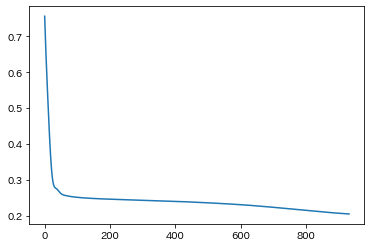

In [25]:
plt.plot(range(len(loss_list)), loss_list)
plt.show()

In [26]:
pred_train = dl(X_train).detach().cpu().numpy()
pred_test = dl(X_test).detach().cpu().numpy()

print(roc_auc_score(y_train.detach().cpu().numpy(), pred_train))

0.8406720194613606


In [28]:
pred_df = test[['SK_ID_CURR']]
pred_df['TARGET'] = pred_test
pred_df.to_csv(DATA_DIR+'dl.csv', index=False)

C:\Users\0000011306852\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [29]:
best_param = dl.state_dict()
torch.save(best_param, f'best_param.pt')